In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [149]:
import pandas as pd

dfs = {
    2019: pd.read_csv('final2019.csv'),
    2020: pd.read_csv('final2020.csv'),
    2021: pd.read_csv('final2021.csv'),
    2022: pd.read_csv('final2022.csv'),
    2023: pd.read_csv('final2023.csv'),
}

for year, df in dfs.items():
    print(f"--- Colonnes {year} ---")
    print(df.columns.tolist(), "\n")

/tmp/ipykernel_209380/1594908137.py:4: DtypeWarning: Columns (7,8,20,22,24,26,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2019: pd.read_csv('final2019.csv'),
/tmp/ipykernel_209380/1594908137.py:5: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2020: pd.read_csv('final2020.csv'),
/tmp/ipykernel_209380/1594908137.py:6: DtypeWarning: Columns (7,8,20,22,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2021: pd.read_csv('final2021.csv'),
/tmp/ipykernel_209380/1594908137.py:7: DtypeWarning: Columns (7,8,20,22,24,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2022: pd.read_csv('final2022.csv'),
/tmp/ipykernel_209380/1594908137.py:8: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2023: pd.read_csv('final2023.csv'),


--- Colonnes 2019 ---
['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment', 'Année_construction', 'Période_construction', 'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)', 'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale', 'surface_terrain', 'longitude', '

In [150]:
# 1) Concaténation
df = pd.concat(dfs.values(), ignore_index=True)
print("Shape après concaténation :", df.shape)

Shape après concaténation : (574251, 51)


In [157]:
import pandas as pd

# 1) Concaténation
df = pd.concat(dfs.values(), ignore_index=True)
print("Shape après concaténation :", df.shape)

# 2) Date → datetime + extraction de l'année
df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
df['year'] = df['date_mutation'].dt.year

Shape après concaténation : (574251, 51)


# code pour changer les groupes traités//de contrôle

In [185]:
# 1) Nettoyage de la variable DPE
df['dpe_clean'] = df['Etiquette_DPE'].str.upper().str.strip()

# 2) Création de l'indicatrice de traitement
# Le groupe de traitement est constitué des logements avec une étiquette DPE F ou G.
df['treat'] = df['dpe_clean'].isin([ 'E','F', 'G']).astype(int)
#A activer si on veut filtrer par maison ou appartement
#df = df[df['Type_bâtiment'] == 'maison']

# 3) Définir l'indicateur 'post' qui vaut 1 si la date de mutation est postérieure à la date clé, sinon 0.
df['post_exact'] = (df['date_mutation'] >= '2021-08-24').astype(int)

# 4) Création de l'indicatrice DID qui est le produit de 'treat' et 'post_exact'
# Cette variable identifie les observations du groupe traité après la période de l'intervention.
df['did'] = df['treat'] * df['post_exact']

# 5) Création de l'indicatrice de groupe de contrôle (0 pour A, B, C, D, 1 pour F, G)
# Le groupe de contrôle est constitué des logements avec une étiquette DPE A, B, C ou D
df['control'] = df['dpe_clean'].isin([ 'A','B','C','D']).astype(int)
# On restreint aux DPE A, B, C, E, F, G uniquement
df = df[df['dpe_clean'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]
#



In [ ]:
#pour vérifier qu'on a bien les groupes de contrôle/traités qu'on souhaite :

In [186]:
print("Répartition des étiquettes DPE par groupe treat:")
print(df.groupby('treat')['dpe_clean'].value_counts())


Répartition des étiquettes DPE par groupe treat:
treat  dpe_clean
0      D            180384
       C             99092
       B             11875
       A              5021
1      E            132841
       F             51436
       G             23809
Name: count, dtype: int64


In [154]:
print("Répartition des étiquettes DPE par type de bâtiment:")
print(df.groupby('Type_bâtiment')['dpe_clean'].value_counts())

Répartition des étiquettes DPE par type de bâtiment:
Type_bâtiment  dpe_clean
appartement    C            82805
               F            42430
               G            18423
               B             7785
               A             2910
immeuble       C               96
               F               59
               B               34
               A               33
               G               28
maison         C            25442
               F            18943
               G            11540
               B             5517
               A             2978
Name: count, dtype: int64


## Nettoyage des valeurs extrêmes

In [187]:
# Sauvegarde du nombre initial d'observations
n_initial = df.shape[0]

# 1. Filtrage des valeurs extrêmes sur 'valeur_fonciere'
q1_vf = df['valeur_fonciere'].quantile(0.025)
q99_vf = df['valeur_fonciere'].quantile(0.975)
df_filtered = df[(df['valeur_fonciere'] >= q1_vf) & (df['valeur_fonciere'] <= q99_vf)]
n_after_valeur = df_filtered.shape[0]
print(f"Après filtrage des valeurs extrêmes de valeur_fonciere : {n_after_valeur:,} (perte de {n_initial - n_after_valeur:,})")

# 2. Filtrage des valeurs extrêmes sur 'surface_reelle_bati'
q1_surf = df_filtered['surface_reelle_bati'].quantile(0.01)
q99_surf = df_filtered['surface_reelle_bati'].quantile(0.99)
df_filtered = df_filtered[(df_filtered['surface_reelle_bati'] >= q1_surf) & (df_filtered['surface_reelle_bati'] <= q99_surf)]
n_final = df_filtered.shape[0]
print(f"Après filtrage aussi sur surface_reelle_bati : {n_final:,} (perte totale de {n_initial - n_final:,})")

# On remplace le DataFrame d'origine par le filtré pour la suite
df = df_filtered.copy()


Après filtrage des valeurs extrêmes de valeur_fonciere : 480,114 (perte de 24,344)
Après filtrage aussi sur surface_reelle_bati : 473,010 (perte totale de 31,448)


## Construction des variables pour le modèle de DIFF n DIFF

In [188]:
# 1) liste des contrôles
controls = [
    'surface_reelle_bati',  # Surface réelle bâtie
    'nombre_pieces_principales',  # Nombre de pièces principales
    'Année_construction',  # Année de construction
    'Type_bâtiment',  # Indicateur de valeurs manquantes dans l'année de construction
]

# 2) construction de la liste complète des variables du modèle
vars_model = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls

# 3) comptage des missing
missing = df[vars_model].isna().sum().rename('n_missing')
total   = df[vars_model].shape[0]
pct     = (missing / total * 100).round(2).rename('pct_missing')
print(pd.concat([missing, pct], axis=1))

# 4) création du jeu clean (drop NA)
df_mod = df.dropna(subset=vars_model)
print(f"\nObservations avant : {total:,}  –  après dropna : {len(df_mod):,}")


                           n_missing  pct_missing
valeur_fonciere                    0         0.00
treat                              0         0.00
post_exact                         0         0.00
did                                0         0.00
code_departement                   0         0.00
surface_reelle_bati                0         0.00
nombre_pieces_principales          0         0.00
Année_construction             84781        17.92
Type_bâtiment                      0         0.00

Observations avant : 473,010  –  après dropna : 388,229


### On voit qu'on perd beaucoup de variables avec année_construction donc on va créer la variable année construction imp qui remplace les valeurs manquantes par la médiane

In [189]:

# 1) Indicateur de missing + imputation pour l'année de construction
df['year_const_miss'] = df['Année_construction'].isna().astype(int)
median_year = df['Année_construction'].median()
df['Année_construction_imp'] = df['Année_construction'].fillna(median_year)

# 2) Nouvelle liste de contrôles (sans surface_terrain, avec l’imputation)
controls2 = [
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'Type_bâtiment',
    'Année_construction_imp',
    'year_const_miss'
]

vars_model2 = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls2

# 3) Nouveau diagnostic des missing
missing2 = df[vars_model2].isna().sum().rename('n_missing')
pct2     = (missing2 / df.shape[0] * 100).round(2).rename('pct_missing')
print(pd.concat([missing2, pct2], axis=1))



# 4) Jeu « clean » après dropna
df_mod2 = df.dropna(subset=vars_model2)
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A','B','C','D', 'E','F', 'G'])]

print(f"\nObservations avant : {df.shape[0]:,}  –  après dropna : {len(df_mod2):,}")

                           n_missing  pct_missing
valeur_fonciere                    0          0.0
treat                              0          0.0
post_exact                         0          0.0
did                                0          0.0
code_departement                   0          0.0
surface_reelle_bati                0          0.0
nombre_pieces_principales          0          0.0
Type_bâtiment                      0          0.0
Année_construction_imp             0          0.0
year_const_miss                    0          0.0

Observations avant : 473,010  –  après dropna : 473,010


## Test "pré-trends parallèles"

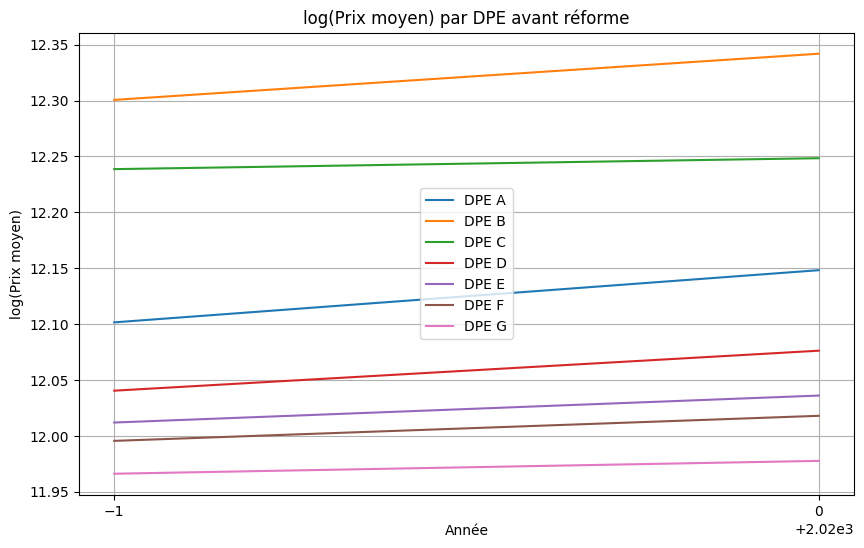

In [190]:
import matplotlib.pyplot as plt
prix_moyen_pre_log = df_mod2[df_mod2['year'] < 2021].copy()
prix_moyen_pre_log['log_prix'] = np.log(prix_moyen_pre_log['valeur_fonciere'])

courbe_log = prix_moyen_pre_log.groupby(['year', 'dpe_clean'])['log_prix'].mean().reset_index()

# Tracer les log(prix)
plt.figure(figsize=(10,6))
for dpe in ['A','B', 'C','D', 'E', 'F', 'G']:  # enlevant A
    subset = courbe_log[courbe_log['dpe_clean'] == dpe]
    plt.plot(subset['year'], subset['log_prix'], label=f'DPE {dpe}')
plt.xticks(courbe_log['year'].unique())
plt.gca().ticklabel_format(style='plain', axis='x')
plt.title("log(Prix moyen) par DPE avant réforme")
plt.ylabel("log(Prix moyen)")
plt.xlabel("Année")
plt.legend()
plt.grid(True)
plt.show()



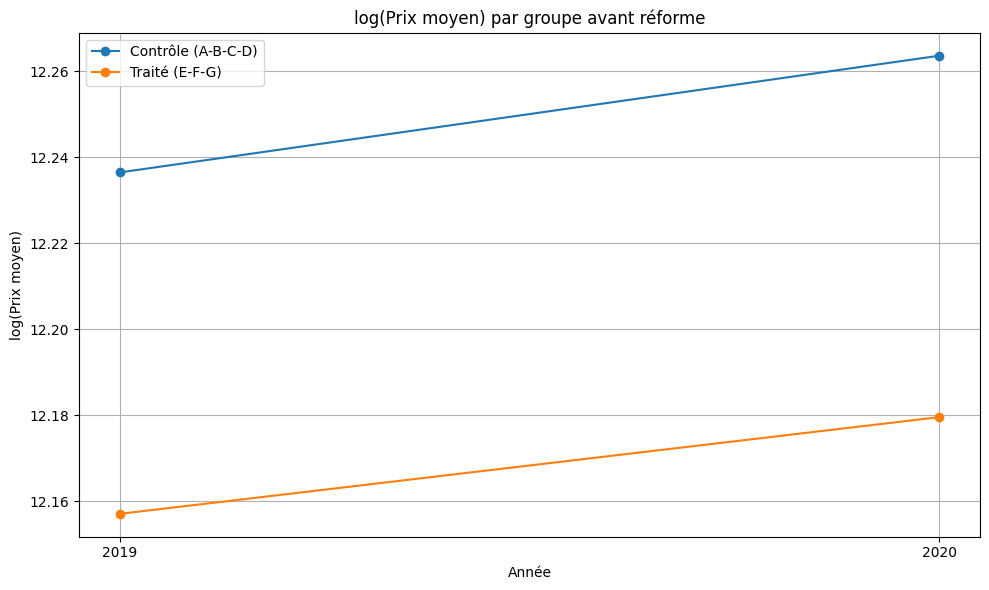

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrer les données avant la réforme
df_pre = df[df['year'].between(2019, 2020)].copy()

# Calcul du log(prix) moyen par année et groupe
grouped = df_pre.groupby(['year', 'treat'])['valeur_fonciere'].mean().reset_index()
grouped['log_prix_moyen'] = np.log(grouped['valeur_fonciere'])
grouped['groupe'] = grouped['treat'].map({0: 'Contrôle (A-B-C-D)', 1: 'Traité (E-F-G)'})

# Tracé
plt.figure(figsize=(10, 6))
for label, grp in grouped.groupby('groupe'):
    plt.plot(grp['year'], grp['log_prix_moyen'], marker='o', label=label)

plt.title("log(Prix moyen) par groupe avant réforme")
plt.xlabel("Année")
plt.ylabel("log(Prix moyen)")
plt.xticks([2019, 2020])
plt.gca().set_xticklabels(['2019', '2020'])  # 🔥 correction définitive
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [130]:
print(df_pre['year'].unique())


[2019 2020]


In [195]:
print(df.groupby('dpe_clean')['treat'].unique())


dpe_clean
A    [0]
B    [0]
C    [0]
D    [0]
E    [1]
F    [1]
G    [1]
Name: treat, dtype: object


## test pre-trend plus robuste

In [191]:
df_pre = df_mod2[df_mod2['date_mutation'] < '2021-08-24']


In [220]:
print(df_pre.columns)


Index(['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment',
       'Année_construction', 'Période_construction',
       'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)',
       'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation',
       'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_natu

In [224]:
df_pre['code_departement'] = df_pre['code_departement'].astype('category')


/tmp/ipykernel_209380/735632507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['code_departement'] = df_pre['code_departement'].astype('category')


In [228]:
df_pre = df_mod2[df_mod2['year'].between(2019, 2020)].copy()
df_pre['code_departement'] = df_pre['code_departement'].astype(str)

df_pre = df_pre.copy()
df_pre['code_departement'] = df_pre['code_departement'].astype(str)
model_test = smf.ols(
    'np.log(valeur_fonciere) ~ C(year) * treat + surface_reelle_bati + Année_construction_imp + Type_bâtiment + nombre_pieces_principales + year_const_miss + C(code_departement)',

    data=df_pre
).fit()
print(model_test.summary())


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.542
Model:                                 OLS   Adj. R-squared:                  0.541
Method:                      Least Squares   F-statistic:                     1362.
Date:                     Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                             11:05:28   Log-Likelihood:                -35231.
No. Observations:                   115344   AIC:                         7.066e+04
Df Residuals:                       115243   BIC:                         7.164e+04
Df Model:                              100                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Pour vérifier l'hypothèse de tendances parallèles on effectue un test de pré-trend : on regarde si avant la réforme, il y avait déjà une tendance différente entre les deux groupes. Concrètement, on ajoute dans le modèle une ou plusieurs interactions entre les années précédant la réforme et le groupe traité, et on teste si leurs coefficients sont significativement différents de zéro.

### est de pré-trend

Dans une régression Diff-in-Diff, l’un des fondements est l’hypothèse de **tendances parallèles** : sans traitement, les groupes traité et contrôle auraient évolué de manière similaire. Pour tester cette hypothèse, on estime un modèle de régression sur la période **précédant la réforme**, avec une interaction entre le groupe traité et les années :

$$
\log(\text{prix}_{it}) = \alpha + \beta_1 \cdot \text{treat}_i + \beta_2 \cdot \text{année}_t + \gamma \cdot (\text{treat}_i \times \text{année}_t) + \text{contrôles} + \varepsilon_{it}
$$

L’objectif est de tester l’hypothèse nulle suivante :

$$
H_0: \gamma = 0
$$

Autrement dit, **aucune différence de tendance** entre les groupes avant la réforme.  
Si ce coefficient $\gamma$ est **non significatif**, cela signifie que les groupes traité et contrôle avaient des trajectoires similaires avant l’intervention → ce qui **valide l’usage du Diff-in-Diff**.

En revanche, si $\gamma$ est **significativement différent de 0**, alors cela suggère que les groupes n’évoluaient pas de manière parallèle avant la réforme. Le Diff-in-Diff risquerait alors d’attribuer à tort l’écart post-réforme au traitement, alors qu’il préexistait.

Dans notre cas, le coefficient d’interaction `C(year)[T.2020]:treat` est de -0.0146 (p = 0.536), ce qui est **non significatif**. Cela **soutient donc l’hypothèse de tendances parallèles** et valide l’approche Diff-in-Diff utilisée par la suite.


# 1ère régression

In [22]:
import statsmodels.formula.api as smf
#commentaire
df_mod2 = df_mod2.copy()
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule du modèle Diff-in-Diff avec variables de contrôle
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    '+ surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards robustes clusterisées par département
model = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model.summary())



                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.139
Model:                                 OLS   Adj. R-squared:                  0.139
Method:                      Least Squares   F-statistic:                     101.5
Date:                     Mon, 28 Apr 2025   Prob (F-statistic):           2.18e-43
Time:                             15:17:11   Log-Likelihood:            -1.1161e+05
No. Observations:                   106682   AIC:                         2.232e+05
Df Residuals:                       106673   BIC:                         2.233e+05
Df Model:                                8                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

hve testtttntest github

# Test de corrélation des variables

In [246]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélection des variables numériques pour le VIF (sans les variables catégorielles comme code_type_local)
X_vif = df_mod2[[
    'did',
    'nombre_pieces_principales',
    'surface_reelle_bati',
    'Année_construction_imp',
    'year_const_miss'
]]

# Ajout de la constante (intercept)
X_vif = sm.add_constant(X_vif)

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


                    Variable        VIF
0                      const  95.614691
1                        did   1.043196
2  nombre_pieces_principales   3.521483
3        surface_reelle_bati   3.540104
4     Année_construction_imp   1.002406
5            year_const_miss   1.037865


In [250]:
# Vérifie les valeurs manquantes dans les colonnes de X
print(X.isnull().sum())


surface_reelle_bati               0
nombre_pieces_principales         0
Année_construction_imp            0
Type_bâtiment                473010
dept_2                            0
                              ...  
dept_86                           0
dept_87                           0
dept_88                           0
dept_89                           0
dept_90                           0
Length: 143, dtype: int64


In [251]:
# Imputer les valeurs manquantes (par exemple, avec la moyenne)
X = X.fillna(X.mean())


In [252]:
# Créer des variables dummies pour code_departement
df_dummies = pd.get_dummies(df['code_departement'], prefix='dept', drop_first=True)

# Concaténer ces variables dummies avec les autres variables explicatives
X = pd.concat([df[['surface_reelle_bati', 'nombre_pieces_principales', 'Année_construction_imp', 'Type_bâtiment']],
               df_dummies], axis=1)


In [253]:
# Vérifie les types de données
print(X.dtypes)

# Si nécessaire, convertir certaines colonnes en numériques
X = X.apply(pd.to_numeric, errors='coerce')


surface_reelle_bati          float64
nombre_pieces_principales    float64
Année_construction_imp       float64
Type_bâtiment                float64
dept_2                          bool
                              ...   
dept_86                         bool
dept_87                         bool
dept_88                         bool
dept_89                         bool
dept_90                         bool
Length: 143, dtype: object


In [254]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher les résultats du VIF
print(vif_data)


/usr/local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [249]:
# Créer des variables dummies pour code_departement
df_dummies = pd.get_dummies(df['code_departement'], prefix='dept', drop_first=True)

# Concaténer ces variables dummies avec les autres variables explicatives
X = pd.concat([df[['surface_reelle_bati', 'nombre_pieces_principales', 'Année_construction_imp', 'Type_bâtiment']],
               df_dummies], axis=1)

# Calculer le VIF pour chaque variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher les résultats du VIF
print(vif_data)

/usr/local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [31]:
df_mod2['dpe_clean'].value_counts()



dpe_clean
D    201131
C    108333
F     61427
G     29991
B     13336
A      5921
Name: count, dtype: int64

## 2e régression : effet fixes

In [27]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~  did + '
    'C(code_departement)+ C(year)+'
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards clusterisées par département
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='HC1',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
model_fe.summary()




ValueError: heteroscedasticity robust covariance does not use keywords

Nouvelle régression sans le clustering

In [241]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~ did + '
    'C(code_departement) + C(year) + '
    'surface_reelle_bati + C(Type_bâtiment) + '
    'nombre_pieces_principales+'
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards robustes (HC1)
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='HC1'
)

# Résultats
model_fe.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.490
Model:                                 OLS   Adj. R-squared:                  0.489
Method:                      Least Squares   F-statistic:                     3933.
Date:                     Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                             12:19:57   Log-Likelihood:            -1.7317e+05
No. Observations:                   473010   AIC:                         3.466e+05
Df Residuals:                       472902   BIC:                         3.478e+05
Df Model:                              107                                         
Covariance Type:                       HC1                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       11.3203      0.010   1097.060      0.000      11.300      11.341
C(code_departement)[T.02]       -0.4765      0.026    -18.241      0.000      -0.528      -0.425
C(code_departement)[T.03]       -0.5415      0.026    -21.022      0.000      -0.592      -0.491
C(code_departement)[T.04]       -0.2079      0.019    -10.952      0.000      -0.245      -0.171
C(code_departement)[T.05]       -0.1116      0.019     -5.798      0.000      -0.149      -0.074
C(code_departement)[T.07]       -0.2745      0.016    -16.959      0.000      -0.306      -0.243
C(code_departement)[T.08]       -0.4242      0.022    -19.257      0.000      -0.467      -0.381
C(code_departement)[T.09]       -0.4373      0.030    -14.696      0.000      -0.496      -0.379
C(code_departement)[T.1]        -0.1298      0.014     -9.131      0.000      -0.158      -0.102
C(code_departement)[T.10]       -0.4523      0.012    -37.038      0.000      -0.476      -0.428
C(code_departement)[T.11]       -0.3278      0.012    -26.665      0.000      -0.352      -0.304
C(code_departement)[T.12]       -0.3336      0.013    -25.039      0.000      -0.360      -0.307
C(code_departement)[T.13]        0.2363      0.010     23.892      0.000       0.217       0.256
C(code_departement)[T.14]       -0.0587      0.010     -5.962      0.000      -0.078      -0.039
C(code_departement)[T.15]       -0.4856      0.019    -25.242      0.000      -0.523      -0.448
C(code_departement)[T.16]       -0.4767      0.014    -34.820      0.000      -0.504      -0.450
C(code_departement)[T.17]        0.0513      0.010      4.995      0.000       0.031       0.071
C(code_departement)[T.18]       -0.5359      0.013    -40.751      0.000      -0.562      -0.510
C(code_departement)[T.19]       -0.4405      0.016    -27.084      0.000      -0.472      -0.409
C(code_departement)[T.2]        -0.4842      0.016    -29.815      0.000      -0.516      -0.452
C(code_departement)[T.21]       -0.1804      0.010    -18.375      0.000      -0.200      -0.161
C(code_departement)[T.22]       -0.2768      0.012    -23.244      0.000      -0.300      -0.253
C(code_departement)[T.23]       -0.5979      0.031    -19.422      0.000      -0.658      -0.538
C(code_departement)[T.24]       -0.3912      0.014    -26.984      0.000      -0.420      -0.363
C(code_departement)[T.25]       -0.2350      0.011    -21.092      0.000      -0.257      -0.213
C(code_departement)[T.26]       -0.2447      0.011    -23.033      0.000      -0.266      -0.224
C(code_departement)[T.27]       -0.2919      0.011    -27.406      0.000      -0.313      -0.271
C(code_departement)[T.28]       -0.2829      0.011    -25.578      0.000      -0.305      -0.261
C(code_departement)[T

In [242]:
residuals=model_test.resid


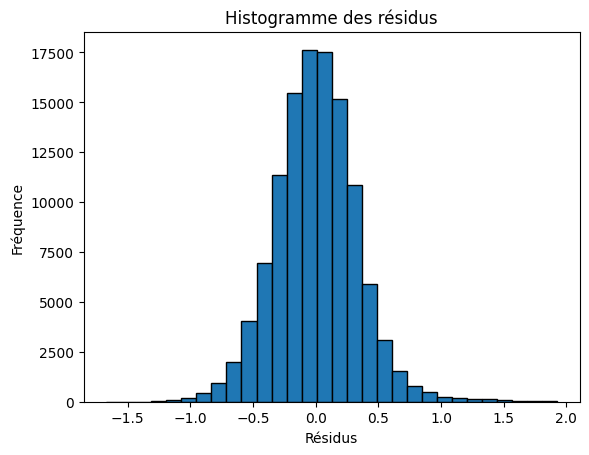

In [243]:
import matplotlib.pyplot as plt

# Tracer un histogramme des résidus
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogramme des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

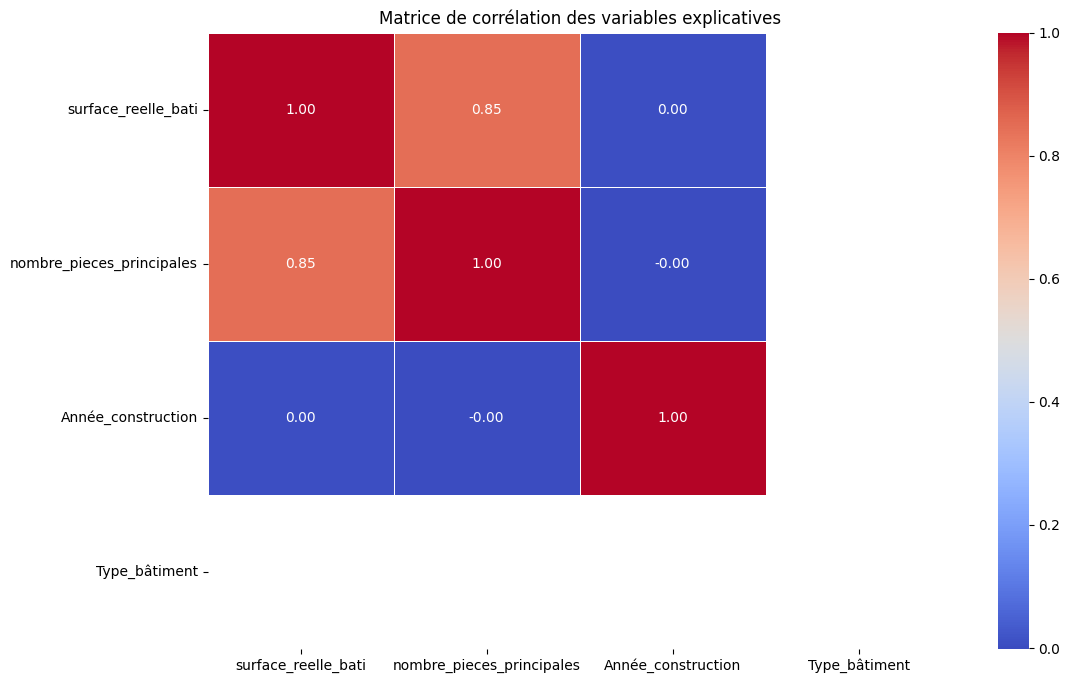

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de corrélation
corr_matrix = df[controls].corr()

# Tracer la heatmap de la corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables explicatives')
plt.show()

In [34]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = ['surface_reelle_bati', 'Type_bâtiment', 'Année_construction_imp', 'year_const_miss', 'nombre_pieces_principales']
X_raw = df_mod2[cols].copy()
X = pd.get_dummies(X_raw, drop_first=True)
X = X.dropna()

# Convertir tous les booléens en int
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)




                    Variable        VIF
0                      const  97.964148
1        surface_reelle_bati   3.851622
2     Année_construction_imp   1.007596
3            year_const_miss   1.004589
4  nombre_pieces_principales   3.630134
5     Type_bâtiment_immeuble   1.000665
6       Type_bâtiment_maison   1.589653


In [12]:
print(df_mod2['code_departement'].value_counts())


code_departement
31    23714
75    17282
34    17224
44    15670
92    14577
      ...  
09      280
02      258
2A       92
48       67
2B       66
Name: count, Length: 97, dtype: int64


In [14]:
# Seuil minimal
min_obs = 300

# Compter les observations par département
dep_counts = df_mod2['code_departement'].value_counts()

# Afficher les départements en dessous du seuil
departements_a_exclure = dep_counts[dep_counts < min_obs]
print(departements_a_exclure)


code_departement
03    296
05    283
09    280
02    258
2A     92
48     67
2B     66
Name: count, dtype: int64


In [16]:
import numpy as np
print(np.linalg.matrix_rank(model_fe.model.exog))
print(model_fe.model.exog.shape)


100
(402497, 100)


In [19]:
model_fe = smf.ols(formula=formula, data=df_mod2).fit(cov_type='HC1')
model_fe.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.541
Model:                                 OLS   Adj. R-squared:                  0.541
Method:                      Least Squares   F-statistic:                     4479.
Date:                     Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                             13:45:19   Log-Likelihood:            -2.3843e+05
No. Observations:                   402497   AIC:                         4.771e+05
Df Residuals:                       402397   BIC:                         4.781e+05
Df Model:                               99                                         
Covariance Type:                       HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.2109      0.014    819.581      0.000      11.184      11.238
C(code_departement)[T.04]    -0.2753      0.026    -10.420      0.000      -0.327      -0.223
C(code_departement)[T.07]    -0.3829      0.022    -17.259      0.000      -0.426      -0.339
C(code_departement)[T.08]    -0.6126      0.028    -22.060      0.000      -0.667      -0.558
C(code_departement)[T.1]     -0.2241      0.019    -11.905      0.000      -0.261      -0.187
C(code_departement)[T.10]    -0.5731      0.016    -36.054      0.000      -0.604      -0.542
C(code_departement)[T.11]    -0.4623      0.015    -29.963      0.000      -0.492      -0.432
C(code_departement)[T.12]    -0.4527      0.017    -26.577      0.000      -0.486      -0.419
C(code_departement)[T.13]     0.2271      0.013     17.660      0.000       0.202       0.252
C(code_departement)[T.14]    -0.0366      0.014     -2.612      0.009      -0.064      -0.009
C(code_departement)[T.15]    -0.6888      0.023    -29.373      0.000      -0.735      -0.643
C(code_departement)[T.16]    -0.5362      0.020    -27.031      0.000      -0.575      -0.497
C(code_departement)[T.17]     0.0157      0.013      1.168      0.243      -0.011       0.042
C(code_departement)[T.18]    -0.6716      0.017    -39.462      0.000      -0.705      -0.638
C(code_departement)[T.19]    -0.5896      0.021    -27.842      0.000      -0.631      -0.548
C(code_departement)[T.2]     -0.6159      0.023    -26.630      0.000      -0.661      -0.571
C(code_departement)[T.21]    -0.2689      0.013    -20.318      0.000      -0.295      -0.243
C(code_departement)[T.22]    -0.3658      0.016    -23.341      0.000      -0.397      -0.335
C(code_departement)[T.23]    -0.8243      0.037    -22.122      0.000      -0.897      -0.751
C(code_departement)[T.24]    -0.5323      0.017    -30.707      0.000      -0.566      -0.498
C(code_departement)[T.25]    -0.3502      0.015    -23.434      0.000      -0.379      -0.321
C(code_departement)[T.26]    -0.2989      0.014    -20.712      0.000      -0.327      -0.271
C(code_departement)[T.27]    -0.3377      0.015    -22.049      0.000      -0.368      -0.308
C(code_departement)[T.28]    -0.3691      0.015    -25.098      0.000      -0.398      -0.340
C(code_departement)[T.29]    -0.3400      0.013    -26.351      0.000      -0.365      -0.315
C(code_departement)[T.3]     -0.6738      0.021    -31.565      0.000      -0.716      -0.632
C(code_departement)[T.30]    -0.2291      0.013    -17.353      0.000      -0.255      -0.203
C(code_departement)[T.31]    -0.0273      0.012     -2.281      0.023      -0.051      -0.004
C(code_departement)[T.32]    -0.5793      0.018    -32.385      0.000      -0.614      -0.544
C(code_departement)[

In [15]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Supprimer les départements avec moins de 300 observations
min_obs = 300
dep_counts = df_mod2['code_departement'].value_counts()
valid_deps = dep_counts[dep_counts >= min_obs].index
df_mod2 = df_mod2[df_mod2['code_departement'].isin(valid_deps)]

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~ did + '
    'C(code_departement) + C(year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Régression avec erreurs standards clusterisées par département
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
model_fe.summary()


/usr/local/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 99, but rank is 10
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.541
Model:                                 OLS   Adj. R-squared:                  0.541
Method:                      Least Squares   F-statistic:                     4548.
Date:                     Tue, 29 Apr 2025   Prob (F-statistic):          5.53e-116
Time:                             13:39:25   Log-Likelihood:            -2.3843e+05
No. Observations:                   402497   AIC:                         4.771e+05
Df Residuals:                       402397   BIC:                         4.781e+05
Df Model:                               99                                         
Covariance Type:                   cluster                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.2109      0.034    330.597      0.000      11.144      11.277
C(code_departement)[T.04]    -0.2753      0.005    -55.261      0.000      -0.285      -0.266
C(code_departement)[T.07]    -0.3829      0.005    -80.029      0.000      -0.392      -0.374
C(code_departement)[T.08]    -0.6126      0.005   -120.887      0.000      -0.623      -0.603
C(code_departement)[T.1]     -0.2241      0.009    -26.063      0.000      -0.241      -0.207
C(code_departement)[T.10]    -0.5731      0.004   -136.173      0.000      -0.581      -0.565
C(code_departement)[T.11]    -0.4623      0.005    -97.568      0.000      -0.472      -0.453
C(code_departement)[T.12]    -0.4527      0.005    -93.444      0.000      -0.462      -0.443
C(code_departement)[T.13]     0.2271      0.004     51.581      0.000       0.219       0.236
C(code_departement)[T.14]    -0.0366      0.006     -6.074      0.000      -0.048      -0.025
C(code_departement)[T.15]    -0.6888      0.005   -143.809      0.000      -0.698      -0.679
C(code_departement)[T.16]    -0.5362      0.007    -82.253      0.000      -0.549      -0.523
C(code_departement)[T.17]     0.0157      0.005      2.924      0.003       0.005       0.026
C(code_departement)[T.18]    -0.6716      0.006   -109.670      0.000      -0.684      -0.660
C(code_departement)[T.19]    -0.5896      0.004   -138.589      0.000      -0.598      -0.581
C(code_departement)[T.2]     -0.6159      0.007    -82.337      0.000      -0.631      -0.601
C(code_departement)[T.21]    -0.2689      0.005    -54.562      0.000      -0.279      -0.259
C(code_departement)[T.22]    -0.3658      0.005    -70.154      0.000      -0.376      -0.356
C(code_departement)[T.23]    -0.8243      0.010    -83.583      0.000      -0.844      -0.805
C(code_departement)[T.24]    -0.5323      0.005   -108.322      0.000      -0.542      -0.523
C(code_departement)[T.25]    -0.3502      0.004    -86.288      0.000      -0.358      -0.342
C(code_departement)[T.26]    -0.2989      0.004    -81.505      0.000      -0.306      -0.292
C(code_departement)[T.27]    -0.3377      0.008    -43.267      0.000      -0.353      -0.322
C(code_departement)[T.28]    -0.3691      0.005    -69.235      0.000      -0.380      -0.359
C(code_departement)[T.29]    -0.3400      0.004    -83.456      0.000      -0.348      -0.332
C(code_departement)[T.3]     -0.6738      0.005   -127.527      0.000      -0.684      -0.663
C(code_departement)[T.30]    -0.2291      0.005    -46.410      0.000      -0.239      -0.219
C(code_departement)[T.31]    -0.0273      0.007     -3.748      0.000      -0.042      -0.013
C(code_departement)[T.32]    -0.5793      0.005   -126.351      0.000      -0.588      -0.570
C(code_departement)[

In [171]:


print(f"Nombre de départements uniques : {df_mod2['code_departement'].nunique()}")
print(f"Nombre d'années uniques : {df_mod2['year'].nunique()}")

Nombre de départements uniques : 97
Nombre d'années uniques : 5


## 3e régression : effets fixes plus fins

In [143]:
# Créer une nouvelle variable d'interaction département × année
df_mod2['dep_year'] = df_mod2['code_departement'].astype(str) + "_" + df_mod2['year'].astype(str)


In [144]:
import statsmodels.formula.api as smf

# Formule avec effets fixes croisés département × année
formula = (
    'np.log(valeur_fonciere) ~ treat + did + '
    'C(dep_year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss'
)

# Estimation avec erreurs standards clusterisées par département
model_cross_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(model_cross_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 471, but rank is 7
  warnings.warn('covariance of constraints does not have full '


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.409
Model:                                 OLS   Adj. R-squared:                  0.409
Method:                      Least Squares   F-statistic:                     2910.
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):          8.55e-109
Time:                             15:55:52   Log-Likelihood:            -3.8605e+05
No. Observations:                   373091   AIC:                         7.730e+05
Df Residuals:                       372619   BIC:                         7.781e+05
Df Model:                              471                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [115]:
taux_macro = pd.DataFrame({
    "year": [2019, 2020, 2021, 2022, 2023],
    "inflation": [1.1, 0.5, 1.6, 5.2, 4.9],  # % annuel
    "taux_interet": [1.2, 1.3, 1.4, 2.0, 3.0]  # taux moyen de prêt immo
})

## 4e régression : inclusion des variables de contrôle économiques

In [116]:
df_mod2 = df_mod2.merge(taux_macro, on="year", how="left")


In [118]:
import statsmodels.formula.api as smf

df_mod2 = df_mod2.copy()
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule du modèle Diff-in-Diff avec variables de contrôle
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    '+ surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss+'
    'inflation + taux_interet'
)

# Régression avec erreurs standards robustes clusterisées par département
model = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.117
Model:                                 OLS   Adj. R-squared:                  0.117
Method:                      Least Squares   F-statistic:                     48.86
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):           2.94e-33
Time:                             15:32:31   Log-Likelihood:            -1.3944e+05
No. Observations:                   110675   AIC:                         2.789e+05
Df Residuals:                       110664   BIC:                         2.790e+05
Df Model:                               10                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [119]:
import statsmodels.formula.api as smf

# S'assurer que 'code_departement' est bien une chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Formule avec effets fixes par département et année
formula = (
    'np.log(valeur_fonciere) ~ treat + did + '
    'C(code_departement) + C(year) + '
    'surface_reelle_bati + Type_bâtiment + '
    'Année_construction_imp + year_const_miss +'
    'inflation + taux_interet'
)

# Régression avec erreurs standards clusterisées par département
model_fe = smf.ols(formula=formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# Résultats
print(model_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 109, but rank is 11
  warnings.warn('covariance of constraints does not have full '


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.397
Model:                                 OLS   Adj. R-squared:                  0.396
Method:                      Least Squares   F-statistic:                -3.004e+14
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):               1.00
Time:                             15:35:29   Log-Likelihood:            -1.1835e+05
No. Observations:                   110675   AIC:                         2.369e+05
Df Residuals:                       110567   BIC:                         2.379e+05
Df Model:                              107                                         
Covariance Type:                   cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [120]:
# 1) Garder uniquement les DPE A à C et E à G
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A', 'B', 'C', 'E', 'F', 'G'])]

# 2) Créer la variable 'treat' pour le groupe traité (E, F, G)
df_mod2['treat'] = df_mod2['dpe_clean'].isin(['E', 'F', 'G']).astype(int)

# 3) Créer la variable 'post_exact' pour les observations après la loi (24 août 2021)
df_mod2['post_exact'] = (df_mod2['date_mutation'] >= '2021-08-24').astype(int)

# 4) Créer l'interaction DID
df_mod2['did'] = df_mod2['treat'] * df_mod2['post_exact']

# 5) Régression DID
formula = (
    'np.log(valeur_fonciere) ~ treat + post_exact + did + '
    'surface_reelle_bati + C(Type_bâtiment) + '
    'Année_construction_imp + year_const_miss'
)

model_did = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(model_did.summary())


                               OLS Regression Results                              
Dep. Variable:     np.log(valeur_fonciere)   R-squared:                       0.116
Model:                                 OLS   Adj. R-squared:                  0.116
Method:                      Least Squares   F-statistic:                     54.16
Date:                     Sat, 19 Apr 2025   Prob (F-statistic):           2.99e-32
Time:                             15:44:43   Log-Likelihood:            -1.3946e+05
No. Observations:                   110675   AIC:                         2.789e+05
Df Residuals:                       110666   BIC:                         2.790e+05
Df Model:                                8                                         
Covariance Type:                   cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [124]:
print("Répartition des étiquettes DPE par groupe treat:")
print(df_mod2.groupby('treat')['dpe_clean'].value_counts())


Répartition des étiquettes DPE par groupe treat:
treat  dpe_clean
0      B            13336
       A             5921
1      F            61427
       G            29991
Name: count, dtype: int64


In [122]:
# 1) Mettre à jour le groupe traité : E, F, G
df_mod2['treat'] = df_mod2['dpe_clean'].isin(['E', 'F', 'G']).astype(int)

# 2) Créer la variable 'control' pour A, B, C
df_mod2['control'] = df_mod2['dpe_clean'].isin(['A', 'B', 'C']).astype(int)

# 3) Filtrer uniquement les DPE A, B, C, E, F, G
df_mod2 = df_mod2[df_mod2['dpe_clean'].isin(['A', 'B', 'C', 'E', 'F', 'G'])]
